Source [link](https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition/#:~:text=1%3A%20Understanding%20Human%20Activity%20Recognition&text=The%20thing%20here%20is%2C%20in,by%20watching%20the%20full%20video.)

In [ ]:
!pip install pytube

In [ ]:
#!pip uninstall -y youtube-dl
#!pip install -U yt-dlp
#import yt_dlp

#Your code using yt-dlp

In [ ]:
!pip install pafy

In [ ]:
import os
import cv2
import math
#import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

#Step 1

In [ ]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

File ‘UCF50.rar’ already there; not retrieving.



#Step 2 ploting examples


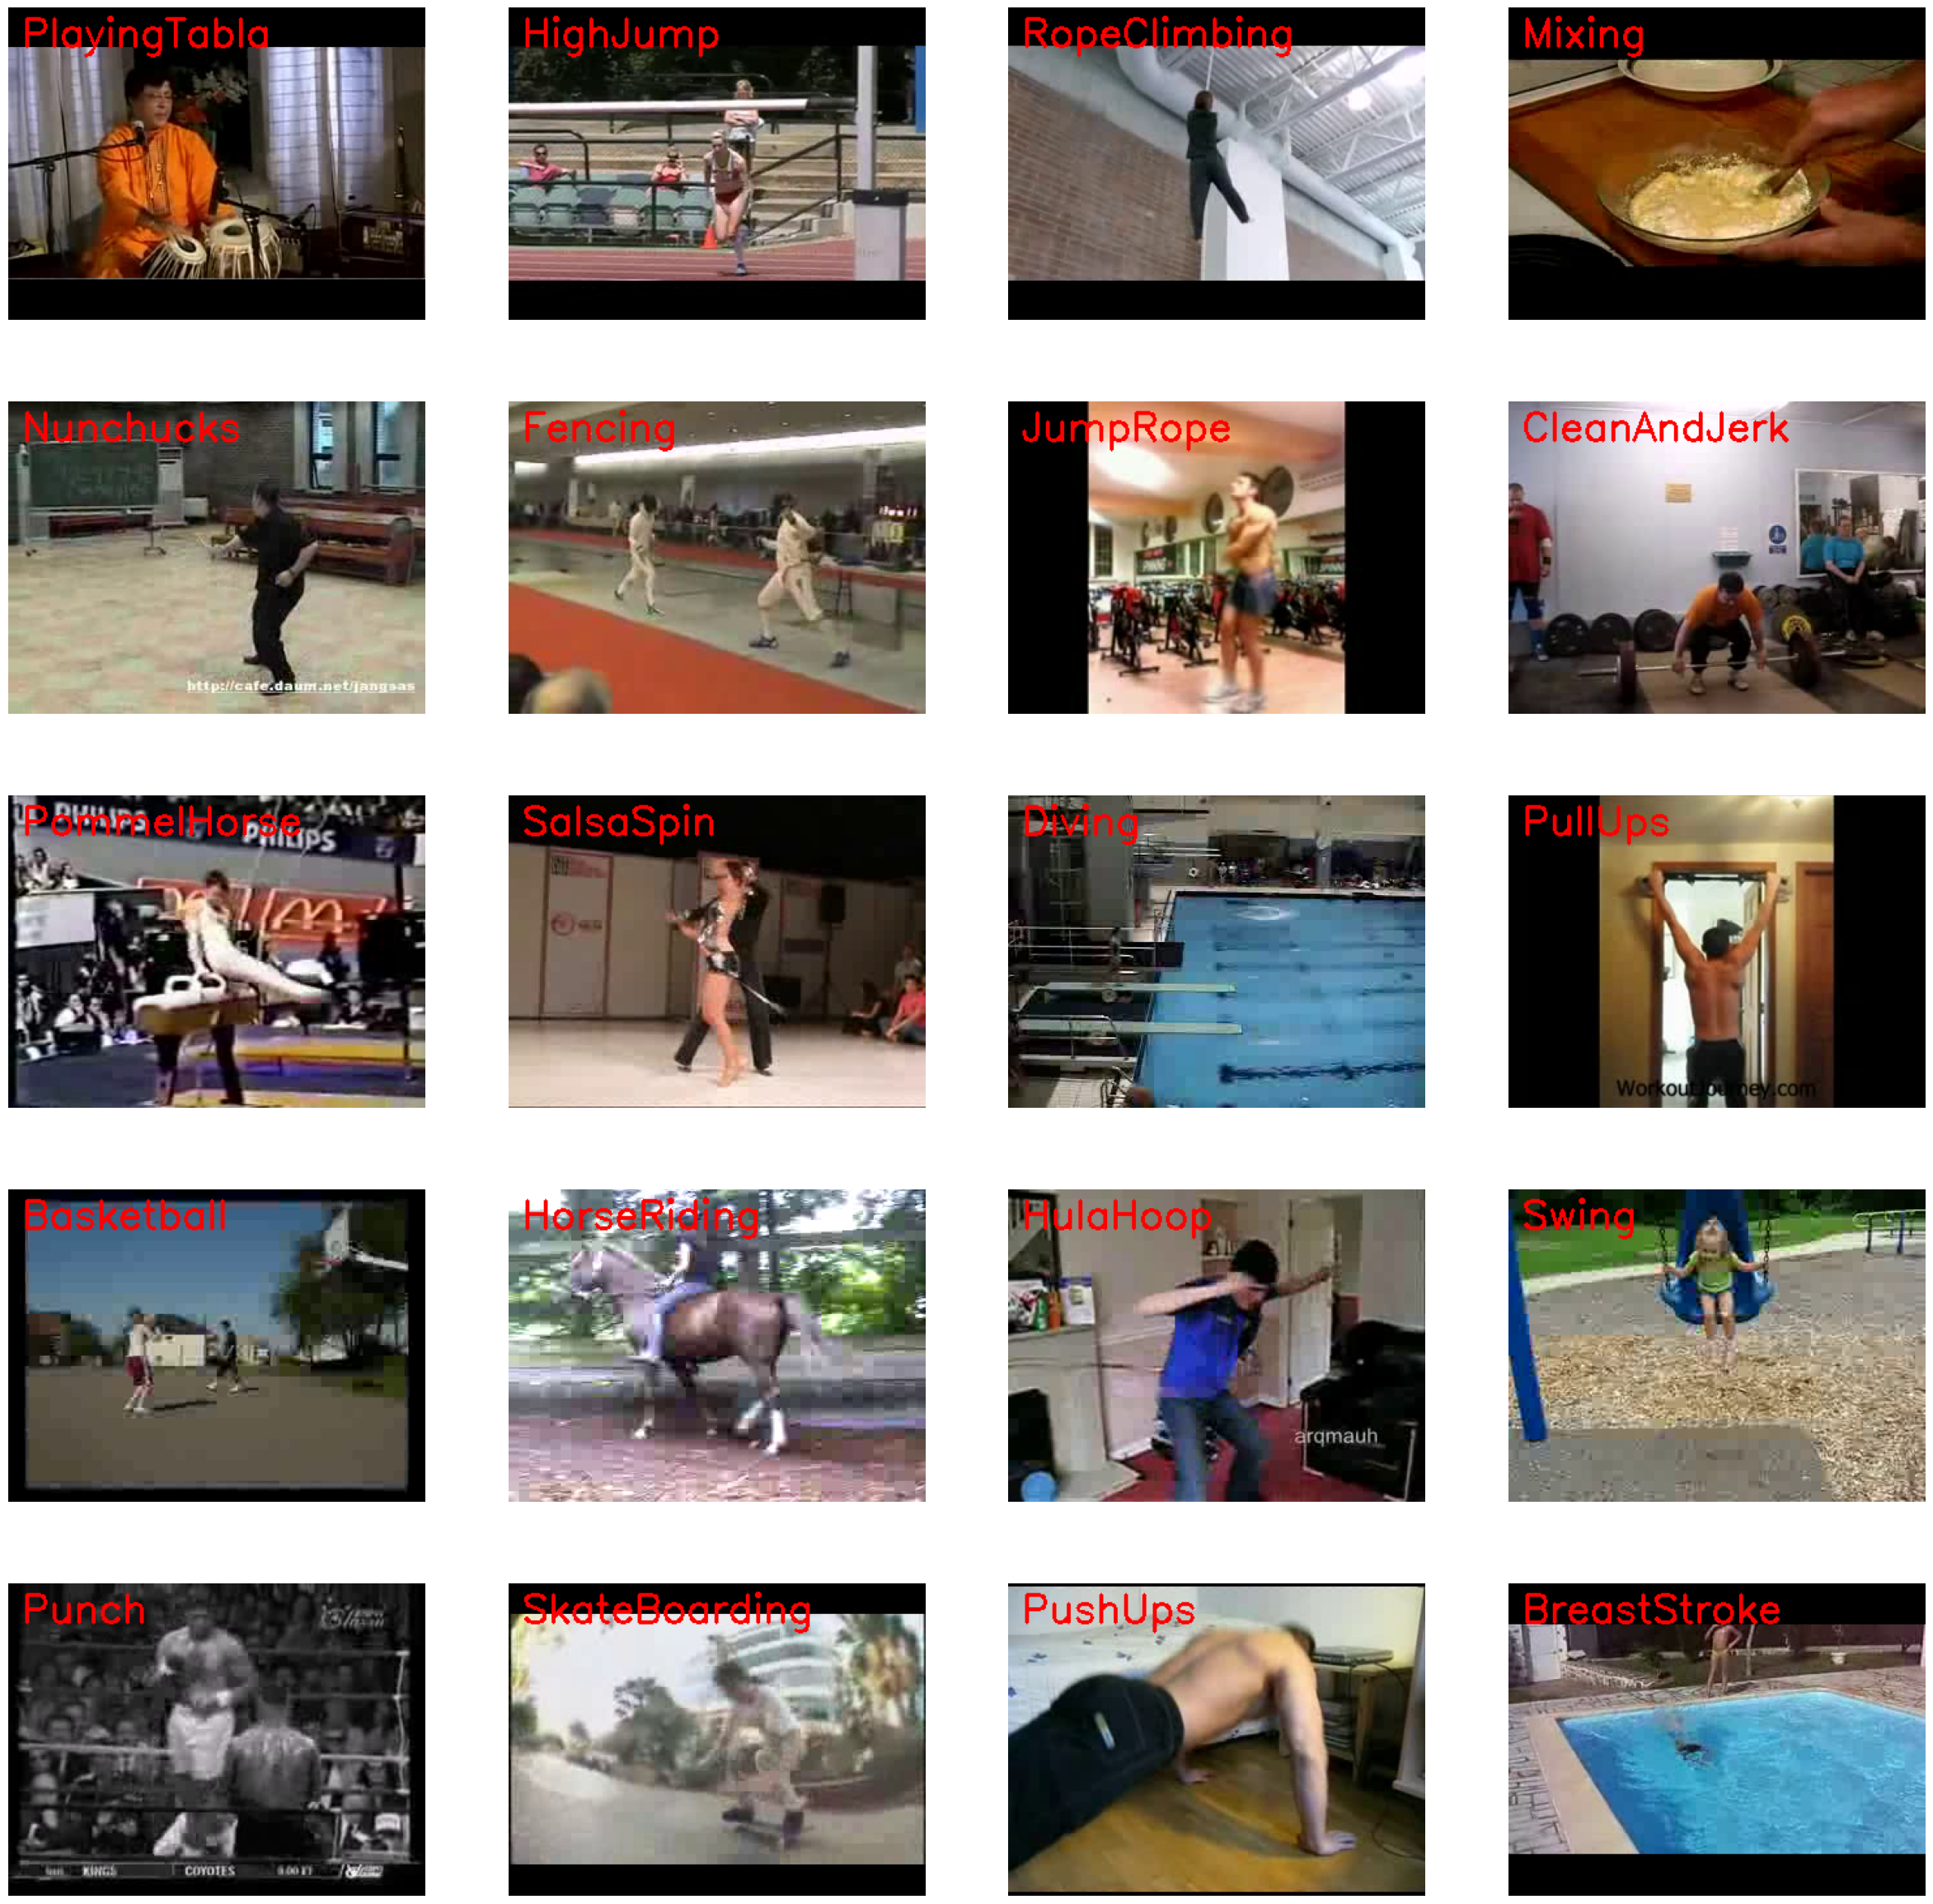

In [ ]:

# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('UCF50')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources.
    video_reader.release()

    # Converting the BGR Frame to RGB Frame
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

#Step 3: Read and Preprocess the Dataset


In [ ]:
all_classes_names = os.listdir('UCF50')
print(all_classes_names)


['HulaHoop', 'Mixing', 'BreastStroke', 'Drumming', 'PizzaTossing', 'RopeClimbing', 'PushUps', 'RockClimbingIndoor', 'Diving', 'Biking', 'Skiing', 'Kayaking', 'PullUps', 'Rowing', 'Swing', 'SoccerJuggling', 'ThrowDiscus', 'Basketball', 'HighJump', 'Fencing', 'JumpingJack', 'WalkingWithDog', 'SalsaSpin', 'VolleyballSpiking', 'CleanAndJerk', 'Skijet', 'Billiards', 'JumpRope', 'HorseRiding', 'Punch', 'TaiChi', 'PoleVault', 'TrampolineJumping', 'PommelHorse', 'YoYo', 'JavelinThrow', 'HorseRace', 'Nunchucks', 'TennisSwing', 'BaseballPitch', 'BenchPress', 'PlayingGuitar', 'JugglingBalls', 'PlayingPiano', 'MilitaryParade', 'GolfSwing', 'SkateBoarding', 'PlayingViolin', 'Lunges', 'PlayingTabla']


In [ ]:
Gym_Activities=['Punch', 'HighJump', 'BenchPress', 'PushUps', 'PullUps', 'JumpingJack', 'Lunges']

Olympic_Games=['HorseRace', 'VolleyballSpiking', 'Biking', 'TaiChi', 'Punch', 'BreastStroke', 'PoleVault', 'ThrowDiscus', 'BaseballPitch', 'HorseRiding', 'Mixing', 'HighJump', 'Fencing', 'Rowing', 'GolfSwing', 'TennisSwing', 'PommelHorse', 'Basketball', 'CleanAndJerk', 'JavelinThrow']

Musical_Instruments=['PlayingTabla', 'PlayingViolin', 'PlayingPiano', 'Drumming', 'PlayingGuitar']

Other=['Billiards', 'Skijet', 'SkateBoarding', 'MilitaryParade', 'JugglingBalls', 'Swing', 'RockClimbingIndoor', 'SalsaSpin', 'Nunchucks', 'HulaHoop', 'RopeClimbing', 'YoYo', 'TrampolineJumping', 'PizzaTossing', 'WalkingWithDog', 'Kayaking', 'JumpRope', 'Skiing', 'Diving', 'SoccerJuggling']

In [ ]:
#all_classes_names=['Skijet', 'PoleVault', 'PizzaTossing', 'PommelHorse', 'SoccerJuggling', 'PlayingViolin', 'HorseRace', 'Skiing', 'TrampolineJumping', 'Drumming', 'PlayingTabla', 'ThrowDiscus', 'RopeClimbing', 'SalsaSpin', 'Rowing', 'BenchPress', 'HighJump', 'RockClimbingIndoor', 'JumpingJack', 'HorseRiding', 'Biking', 'HulaHoop', 'Billiards', 'Fencing', 'Swing', 'PlayingGuitar', 'Kayaking', 'TennisSwing', 'Punch', 'Lunges', 'YoYo', 'CleanAndJerk', 'PushUps', 'SkateBoarding', 'JugglingBalls', 'BreastStroke', 'VolleyballSpiking', 'Mixing', 'TaiChi', 'WalkingWithDog', 'BaseballPitch', 'PullUps', 'Basketball', 'JavelinThrow', 'MilitaryParade', 'GolfSwing', 'PlayingPiano', 'Diving', 'JumpRope','Nunchucks']

In [ ]:
image_height, image_width = 64, 64
max_images_per_class = 700

dataset_directory = "UCF50"
classes_list = Musical_Instruments #["Biking", "JumpingJack","PlayingTabla","Punch"]
# classes_list = all_classes_names
model_output_size = len(classes_list)

In [ ]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []

    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file
        success, frame = video_reader.read()

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Closing the VideoCapture object and releasing all resources.
    video_reader.release()

    # returning the frames list
    return frames_list

In [ ]:

def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = []
    features = []
    labels = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')

        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)

        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)

        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels

In [ ]:
features, labels = create_dataset()


Extracting Data of Class: PlayingTabla
Extracting Data of Class: PlayingViolin
Extracting Data of Class: PlayingPiano
Extracting Data of Class: Drumming
Extracting Data of Class: PlayingGuitar


In [ ]:
features.shape

(3500, 64, 64, 3)

In [ ]:
len(labels)

3500

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

#Step 4: Split the Data into Train and Test Sets

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)


#Step 5: Construct the Model


In [ ]:
def create_model():
  model = Sequential()

  # Convolutional Layers
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, 3)))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Global Average Pooling
  model.add(GlobalAveragePooling2D())

  # Fully Connected Layers
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))  # Adding dropout for regularization
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())

  # Output Layer
  model.add(Dense(model_output_size, activation='softmax'))

  # Printing the models summary
  model.summary()

  return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization_8 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_9 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                      

In [ ]:
'''
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")
'''

'\n# Let\'s create a function that will construct our model\ndef create_model():\n\n    # We will use a Sequential model for model construction\n    model = Sequential()\n\n    # Defining The Model Architecture\n    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = \'relu\', input_shape = (image_height, image_width, 3)))\n    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = \'relu\'))\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D(pool_size = (2, 2)))\n    model.add(GlobalAveragePooling2D())\n    model.add(Dense(256, activation = \'relu\'))\n    model.add(BatchNormalization())\n    model.add(Dense(model_output_size, activation = \'softmax\'))\n\n    # Printing the models summary\n    model.summary()\n\n    return model\n\n\n# Calling the create_model method\nmodel = create_model()\n\nprint("Model Created Successfully!")\n'

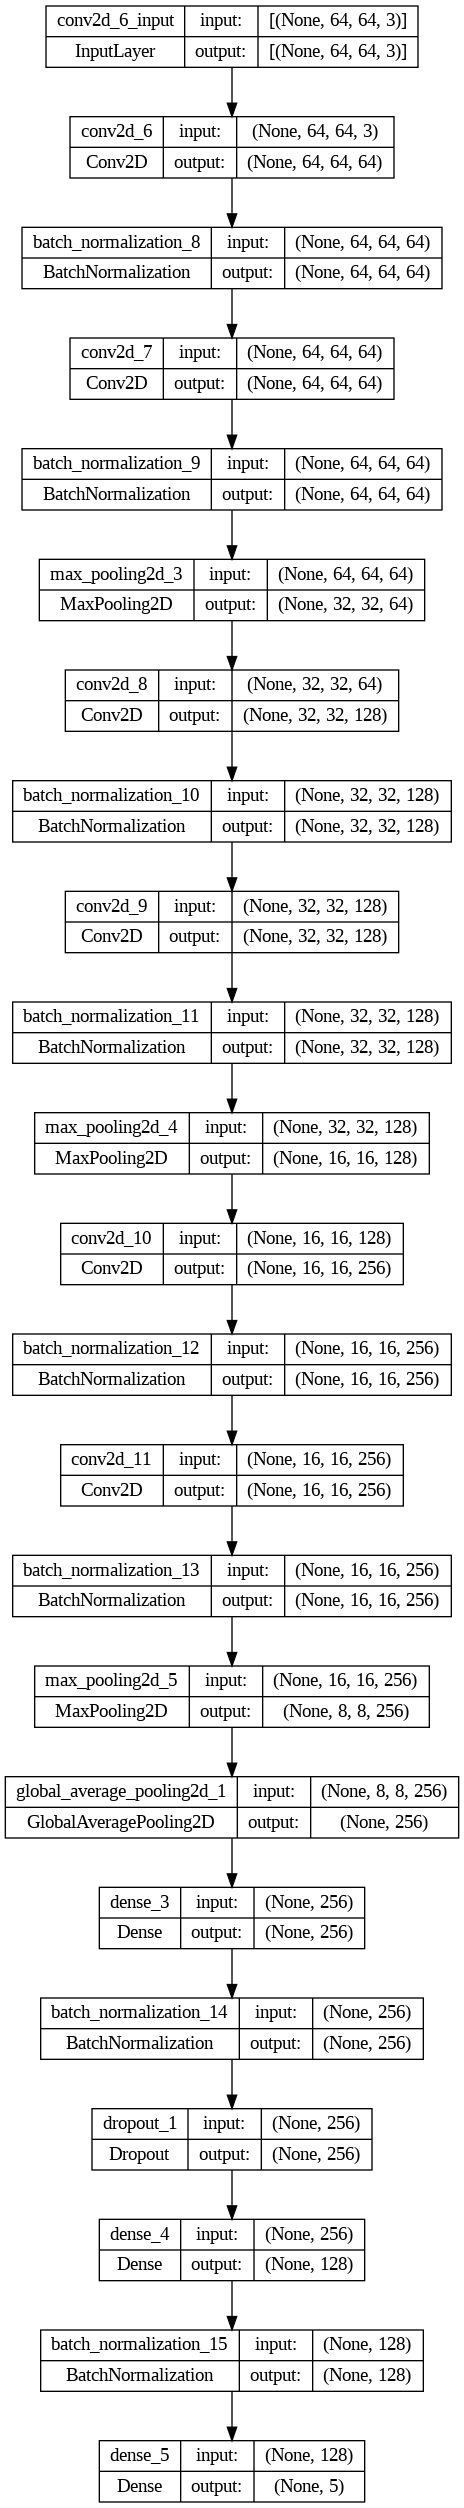

In [ ]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)


#Step 6: Compile and Train the Model


In [ ]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 11, batch_size = 32 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/11
70/70 [==============================] - 8s 45ms/step - loss: 1.2425 - accuracy: 0.5152 - val_loss: 2.0368 - val_accuracy: 0.2179
Epoch 2/11
70/70 [==============================] - 2s 35ms/step - loss: 0.5988 - accuracy: 0.7808 - val_loss: 3.0722 - val_accuracy: 0.2125
Epoch 3/11
70/70 [==============================] - 2s 31ms/step - loss: 0.3389 - accuracy: 0.8875 - val_loss: 4.9141 - val_accuracy: 0.1464
Epoch 4/11
70/70 [==============================] - 2s 33ms/step - loss: 0.2116 - accuracy: 0.9388 - val_loss: 4.9128 - val_accuracy: 0.2607
Epoch 5/11
70/70 [==============================] - 2s 31ms/step - loss: 0.1398 - accuracy: 0.9509 - val_loss: 5.4313 - val_accuracy: 0.2089
Epoch 6/11
70/70 [==============================] - 2s 34ms/step - loss: 0.1450 - accuracy: 0.9540 - val_loss: 5.3109 - val_accuracy: 0.2714
Epoch 7/11
70/70 [==============================] - 2s 35ms/step - loss: 0.0777 - accuracy: 0.9750 - val_loss: 2.4474 - val_accuracy: 0.4714
Epoch 8/11
70

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)


22/22 [==============================] - 0s 10ms/step - loss: 0.6576 - accuracy: 0.8271


##Save Your Model


In [ ]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
#model_name = f"Model Date_Time {current_date_time_string} Accuracy {model_evaluation_accuracy}.h5"

model_name = f"Model_Musical_Instruments Date_Time {current_date_time_string} Accuracy {model_evaluation_accuracy}.h5"
# Saving your Model
model.save(model_name)

##Load saved model

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
#model = tf.keras.models.load_model('/content/Model_All_Activities_New Date_Time 2024_04_06__06_50_50 Accuracy 0.9014000296592712.h5')

In [ ]:
#model = tf.keras.models.load_model('/content/Model_All_Activities_New Date_Time 2024_04_06__06_50_50 Accuracy 0.9014000296592712.h5')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

ValueError: mount failed

##Step 7: Plot Model’s Loss and Accuracy Curves


In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

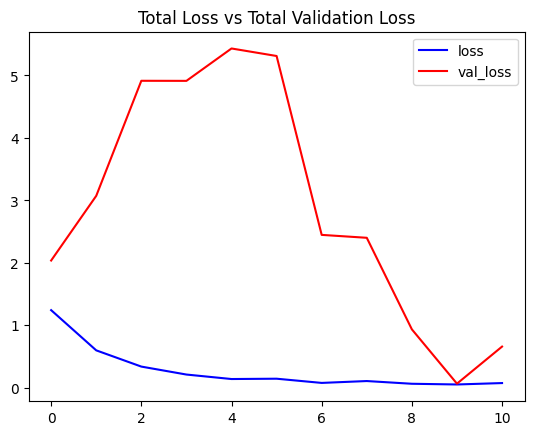

In [ ]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')


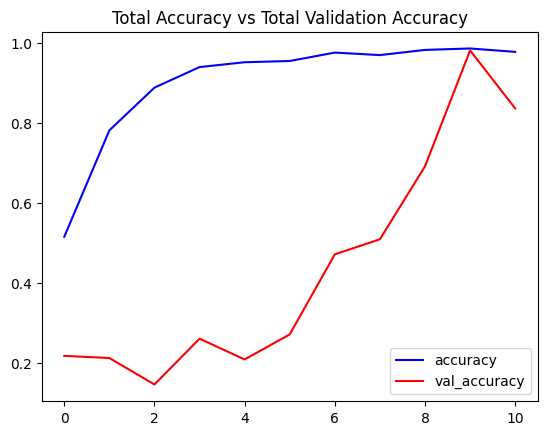

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


#Download video


In [ ]:
'''
def download_youtube_videos(youtube_video_url, output_directory):
    # Creating a Video object which includes useful information regarding the youtube video.
    video = pafy.new(youtube_video_url)

    # Getting the best available quality object for the youtube video.
    video_best = video.getbest()

    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'

    # Downloading the youtube video at the best available quality.
    video_best.download(filepath = output_file_path, quiet = True)

    # Returning Video Title
    return video.title
'''

"\ndef download_youtube_videos(youtube_video_url, output_directory):\n    # Creating a Video object which includes useful information regarding the youtube video.\n    video = pafy.new(youtube_video_url)\n\n    # Getting the best available quality object for the youtube video.\n    video_best = video.getbest()\n\n    # Constructing the Output File Path\n    output_file_path = f'{output_directory}/{video.title}.mp4'\n\n    # Downloading the youtube video at the best available quality.\n    video_best.download(filepath = output_file_path, quiet = True)\n\n    # Returning Video Title\n    return video.title\n"

#Step 8: Make Predictions with the Model:


##Function To Predict on Live Videos Using Moving Average:

In [ ]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True:

        # Reading The Frame
        status, frame = video_reader.read()

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]

            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()


    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them.
    video_reader.release()
    video_writer.release()

##Working with webcam


In [ ]:
from IPython.display import display, Javascript,HTML
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");

      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});

      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;
      video.muted = true;

      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);

      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();

      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))

In [ ]:
video_path = "webcam_video.mp4"
#record_video(video_path)

In [ ]:
'''Uncomment to run webcam results
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 25

# Constructing The Output YouTube Video Path
output_video_file_path = f'webcam -Output-WSize {window_size}.mp4'
input_video_file_path = '/content/webcam_video.mp4'
# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)


# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)
'''

"Uncomment to run webcam results\n# Setting sthe Window Size which will be used by the Rolling Average Proces\nwindow_size = 25\n\n# Constructing The Output YouTube Video Path\noutput_video_file_path = f'webcam -Output-WSize {window_size}.mp4'\ninput_video_file_path = '/content/webcam_video.mp4'\n# Calling the predict_on_live_video method to start the Prediction.\npredict_on_live_video(input_video_file_path, output_video_file_path, window_size)\n\n\n# Play Video File in the Notebook\nVideoFileClip(output_video_file_path).ipython_display(width = 700)\n"

##Download a Test Video:


##Results Without Using Moving Average:
(Give training data video to predict Activity)

In [ ]:
#model = tf.keras.models.load_model('/content/Model_Olympic_Games Date_Time 2024_04_07__10_17_14 Accuracy 0.9039999842643738.h5')

In [ ]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 25

# Constructing The Output YouTube Video Path
output_video_file_path = f'Music_Output -Output-WSize {window_size}.mp4'
input_video_file_path = '/content/UCF50/PlayingGuitar/v_PlayingGuitar_g01_c02.avi'
# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

1/1 [==============================] - 0s 18ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  84%|████████▎ | 210/251 [00:00<00:00, 726.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file Music_Output -Output-WSize 25.mp4, 230400 bytes wanted but 0 bytes read,at frame 250/251, at time 10.42/10.42 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4


##Results When Using Moving Average:
(Give training data video to predict activity)


In [ ]:
#model = combined_model#tf.keras.models.load_model('/content/combined_model2.h5')

In [ ]:
# Setting the Window Size which will be used by the Rolling Average Process
window_size = 25

# Constructing The Output YouTube Video Path
# output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'
output_video_file_path = f'HorseRiding -Output-WSize {window_size}.mp4'
input_video_file_path = '/content/horse riding.mp4'

# Calling the predict_on_live_video method to start the Prediction and Rolling Average Process
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

#Step 9: Using Single-Frame CNN Method:


In [ ]:
def make_average_predictions(video_file_path, predictions_frames_count):

    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count):

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read()

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")

    # Closing the VideoCapture Object and releasing all resources held by it.
    video_reader.release()

# Working with Youtube Video

In [ ]:
from pytube import YouTube

# Where to save
SAVE_PATH = 'Youtube_Videos'

# Link of the video to be downloaded
link = "https://www.youtube.com/watch?v=rtFv_-QT26w"

try:
    # Object creation using YouTube
    yt = YouTube(link)
except Exception as e:
    print(f"Connection Error: {e}")

# Get the video streams
video_streams = yt.streams.filter(file_extension="mp4", res="240p")

# title of the file --> yt.title

# Get the first stream (you can choose a different one if needed)
d_video = video_streams[0]

try:
    # Downloading the video
    d_video.download(output_path=SAVE_PATH)

    print(f"Downloaded video: {yt.title}")

except Exception as e:
    print(f"Some Error: {e}")

print('Task Completed!')
input_video_file_path = f'{"Youtube_Videos"}/{yt.title}.mp4'

Downloaded video: Shubhashree - Tere Liye ( Veer Zaara ) - Piano Cover
Task Completed!


In [ ]:
yt.title

'Shubhashree - Tere Liye ( Veer Zaara ) - Piano Cover'

#Youtube Video Prediction Using Labeling
(Choose low-duration video & Give Output file name)

In [ ]:
# Setting the Window Size which will be used by the Rolling Average Process
window_size = 25

# Constructing The Output YouTube Video Path
# output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'
output_video_file_path = f'Youtube Video Tabla -Output-WSize {window_size}.mp4'
input_video_file_path = '/content/Youtube_Videos/Shubhashree - Tere Liye ( Veer Zaara ) - Piano Cover.mp4'

# Calling the predict_on_live_video method to start the Prediction and Rolling Average Process
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700,maxduration=100)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


ValueError: The duration of video __temp__.mp4 (213.8) exceeds the 'maxduration' attribute. You can increase 'maxduration', by passing 'maxduration' parameterto ipython_display function.But note that embedding large videos may take all the memory away !

# Youtube Video Prediction Using make_average_predicton
(By giving Predictions across classes)

In [ ]:
input_video_file_path

In [ ]:

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700,maxduration=500)

#Combining models

In [ ]:
import keras

def combine_models(model1, model2, model3):
  """Combines three saved models into a single model."""
  input_layer = keras.Input(shape=model1.input_shape)
  x1 = model1(input_layer)
  x2 = model2(input_layer)
  x3 = model3(input_layer)
  concatenated = keras.layers.Concatenate()([x1, x2, x3])
  output_layer = keras.layers.Dense(50, activation="softmax")(concatenated)
  model = keras.Model(input_layer, output_layer)
  return model

model1 = keras.models.load_model("/content/Model_All_Activities_New Date_Time 2024_04_06__06_50_50 Accuracy 0.9014000296592712.h5")
model2 = keras.models.load_model("/content/Model_Musical_Instruments Date_Time 2024_04_04__19_34_56 Accuracy 0.9760000109672546.h5")
model3 = keras.models.load_model("/content/Model_Physical_Activity Date_Time 2024_04_04__19_50_38 Accuracy 0.9440624713897705.h5")

combined_model = combine_models(model1, model2, model3)

#combined_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#combined_model.fit(x_train, y_train, epochs=10)


In [ ]:
model1 = tf.keras.models.load_model("/content/Model_All_Activities_New Date_Time 2024_04_06__06_50_50 Accuracy 0.9014000296592712.h5")
model2 = tf.keras.models.load_model("/content/Model_Musical_Instruments Date_Time 2024_04_04__19_34_56 Accuracy 0.9760000109672546.h5")
model3 = tf.keras.models.load_model("/content/Model_Physical_Activity Date_Time 2024_04_04__19_50_38 Accuracy 0.9440624713897705.h5")


In [ ]:
from keras.models import load_model, Model
from keras.layers import Input

# Load the models
#model1 = load_model('model1.h5')
#model2 = load_model('model2.h5')
#model3 = load_model('model3.h5')

# Extract layers
model1_layers = model1.layers
model2_layers = model2.layers
model3_layers = model3.layers

input_shape1 =None,64,64,3
input_shape2 =64,64,3
input_shape3 =64,64,3

# Create input layers
input1 = Input(shape=input_shape1)
input2 = Input(shape=input_shape2)
input3 = Input(shape=input_shape3)

# Connect layers
output1 = model1_layers[0](input1)
output2 = model2_layers[0](input2)
output3 = model3_layers[0](input3)

# Create output layers
output1 = model1_layers[-1](output1)
output2 = model2_layers[-1](output2)
output3 = model3_layers[-1](output3)

# Combine models
combined_model = Model(inputs=[input1, input2, input3], outputs=[output1, output2, output3])

# Compile and train the combined model
#combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:

input_shape1 =64,64,3
input_shape2 =64,64,3
input_shape3 =64,64,3

In [ ]:
from keras.models import load_model, Model
from keras.layers import Input

# Load the pre-trained models
#model1 = load_model('model1.h5')
#model2 = load_model('model2.h5')
#model3 = load_model('model3.h5')

# Rename layers to ensure uniqueness
for layer in model1.layers:
    layer._name = layer.name + '_model1'

for layer in model2.layers:
    layer._name = layer.name + '_model2'

for layer in model3.layers:
    layer._name = layer.name + '_model3'

# Create input layers for each model
input1 = Input(shape=input_shape1)
input2 = Input(shape=input_shape2)
input3 = Input(shape=input_shape3)

# Connect input layers to the respective models
output1 = model1(input1)
output2 = model2(input2)
output3 = model3(input3)

# Create a new model with combined inputs and outputs
combined_model = Model(inputs=[input1, input2, input3], outputs=[output1, output2, output3])


In [ ]:
# Saving your Model
combined_model.save("combined_model2.h5")